In [9]:
import os
import numpy as np
import pandas as pd
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt

In [10]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha, fc1_dims, fc2_dims, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
            nn.Linear(*input_dims, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, n_actions),
            nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        dist = self.forward(state)
        action = dist.sample()
        action = T.squeeze(action).item()
        return action

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

    def flatten(self, images):
        flatten_images = []
        for i in range(images.shape[0]):
            image = np.array(images[i])
            flatten_images.append(image.flatten())
        return np.array(flatten_images)

In [11]:
# ann = ActorNetwork(n_actions=10, input_dims=(64, ), fc1_dims=128, fc2_dims=128, chkpt_dir='tmp/ppo')
# ann.load_checkpoint()
# mnist = load_digits()
# X = mnist['images']
# X = ann.flatten(X)
# Y = mnist['target']

# x_train, x_test, self.labels, self.labels_test = train_test_split(self.images, self.labels, 
#                                                                                         test_size=0.2, train_size=0.8, 
#                                                                                         shuffle=True)

In [12]:
def smoothing(arr, radius=10):
    y = []
    for i in range(len(arr)):
        y.append(np.mean(arr[i:radius+i]))
    return np.array(y)
    
# Import files and Generate plot data
plotdata_1 = pd.read_csv('data/PPO-MNIST-rewards-train.csv', index_col=0)

# Basic plotdata
n_episodes, n_trials = plotdata_1.shape
train_x = [i+1 for i in range(n_episodes)]

# Mean and variance
mean_vals_1 = plotdata_1.mean(axis=1)
std_vals_1 = plotdata_1.std(axis=1)

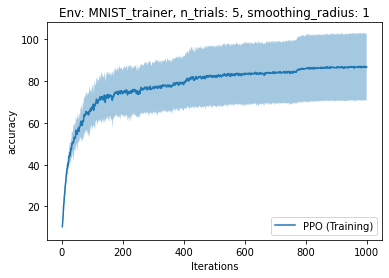

In [13]:
radius = 1
mean_vals = smoothing(mean_vals_1, radius)
std_vals = smoothing(std_vals_1, radius)

plt.figure()

plt.title("Env: MNIST_trainer, n_trials: {}, smoothing_radius: {}".format(n_trials, radius))
plt.xlabel("Iterations")
plt.ylabel("accuracy")

H = 1000
plt.plot(train_x[:H], mean_vals[:H], label='PPO (Training)')
plt.fill_between(train_x[:H], mean_vals[:H]-std_vals[:H], mean_vals[:H]+std_vals[:H], alpha=0.4)

plt.legend(loc='lower right')

plt.savefig('plots/MNIST-score.png')
plt.show()